# Models

Matt Thomas, Max McGaw, Liam Mulcahy, Will Carruthers

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#We can use the sample.csv to speed things up while tuning models
#df = spark.read.csv('train_data.csv', inferSchema=True, header=True)
df = spark.read.csv('sample.csv', inferSchema=True, header=True)

In [5]:
df.show(2)

+------+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+
|   _c0|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|debt_settlement_flag|grade_feature|emp_length_low|
+------+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+
|625057|                 0|   4000.0| 36 months|   15.05|      MORTGAGE|   302373.0|  4558.1553|  100000.0|        CA|         675.0|        2899.73|                   N|           CD|             0|
|394994|                 0|  10000.0| 60 months|   12.69|      MORTGAGE|    93524.0|  11656.099|   80000.0|        WY|         660.0|         8055.0|                   N|           CD|             0|


In [5]:
dfs = df.select([col for col in df.columns if col not in ['_c0']])

In [6]:
dfs.show(5)

+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|debt_settlement_flag|grade_feature|emp_length_low|
+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+
|                 0|  20000.0| 60 months|     9.8|          RENT|    84037.0|   23387.47|   75000.0|        OH|         690.0|       13669.82|                   N|           AB|             0|
|                 0|   3000.0| 36 months|   14.08|          RENT|    27195.0|     1537.4|   24000.0|        TX|         695.0|         102.65|                   N|           CD|             1|
|                 0|  16000.0| 36 m

In [7]:
dfs.printSchema()

root
 |-- loan_status_binary: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- tot_cur_bal: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- debt_settlement_flag: string (nullable = true)
 |-- grade_feature: string (nullable = true)
 |-- emp_length_low: integer (nullable = true)



## Logistic Regression

In [6]:
train, test = dfs.randomSplit([0.8, 0.2], seed=12345)

In [28]:
categories = ['home_ownership', 'term', 'debt_settlement_flag', 'grade_feature']
stages = []

In [29]:
for col in categories:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=col + "classVec")
    stages += [stringIndexer, encoder]

In [30]:
scaled_vectors = VectorAssembler(inputCols = ['loan_amnt',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low','tot_cur_bal'],
                                 outputCol='vector_features')

In [31]:
scaler = StandardScaler(inputCol='vector_features', outputCol='scaled_features')

In [32]:
labelIndexer = StringIndexer(inputCol='loan_status_binary', outputCol='label')

In [33]:
#AT added
assembler = VectorAssembler(inputCols=['scaled_features', 'home_ownershipclassVec', 'termclassVec', \
                                       'debt_settlement_flagclassVec','grade_featureclassVec' ], outputCol='features')

In [34]:
stages += [scaled_vectors, scaler, labelIndexer, assembler]

In [35]:
lr = LogisticRegression(maxIter=10, regParam=0.1)
stages += [lr]
stages

[StringIndexer_c7a6eac95820,
 OneHotEncoder_ec27ea10acdf,
 StringIndexer_db80c5b7ba5f,
 OneHotEncoder_12375614ba24,
 StringIndexer_b5497c92656a,
 OneHotEncoder_00b554dc73d5,
 StringIndexer_d1446e3556f4,
 OneHotEncoder_3869820922a7,
 VectorAssembler_da0bdd6fcbc4,
 StandardScaler_02532240d896,
 StringIndexer_e62477fcb392,
 VectorAssembler_d10dbb50de4d,
 LogisticRegression_278516752709]

In [36]:
pipeline = Pipeline(stages=stages)

In [37]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, .001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.8, 1.0])\
    .build()

In [38]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [39]:
# Fit the pipeline
model = crossval.fit(train)

In [40]:
# Make a prediction
prediction = model.transform(test)
prediction.show(2)

+------------------+---------+----------+--------+--------------+-------------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+--------------------+----------------------+----------+-------------+--------------------------+----------------------------+-------------------+---------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|  tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|debt_settlement_flag|grade_feature|emp_length_low|home_ownership_Index|home_ownershipclassVec|term_Index| termclassVec|debt_settlement_flag_Index|debt_settlement_flagclassVec|grade_feature_Index|grade_featureclassVec|     vector_features|     scaled_features|label|            features|       rawPrediction|         probability|prediction|
+------------------+---------+--

In [41]:
prediction = prediction.withColumn("loan_status_binary", df["loan_status_binary"].cast('float'))
#This is necessary to compare predictions with actual values

In [42]:
#Calculates area under Precision-Recall curve
evaluator = BinaryClassificationEvaluator(labelCol='loan_status_binary', \
                                          metricName='areaUnderPR')

In [43]:
evaluator.evaluate(prediction) #calculates area under P-R curve

0.42803982707607313

In [44]:
f1_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',\
                                                 labelCol='loan_status_binary',\
                                                 metricName='f1')

In [45]:
f1_evaluator.evaluate(prediction) #f1 score

0.859761380158177

In [46]:
trainingSummary = model.bestModel.stages[-1].summary
trainingSummary.accuracy

0.8927768588030708

In [47]:
trainingSummary.truePositiveRateByLabel

[0.9927691074504355, 0.1515823766677009]

In [48]:
#There's probably a better way, but this shows the best parameters
bestPipeline = model.bestModel
bestLRModel = bestPipeline.stages[-1]
bestParams = bestLRModel.extractParamMap()
bestParams

{Param(parent='LogisticRegression_278516752709', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_278516752709', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_278516752709', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_278516752709', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_278516752709', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_278516752709', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_278516752709', name='maxIter', doc='maximum number of iterations (>= 0)'): 

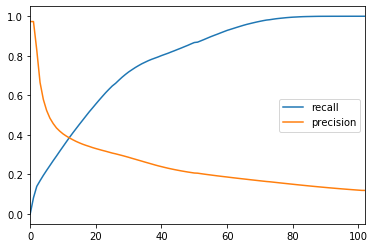

In [49]:
#plotting precision-recall curve
pr = trainingSummary.pr.toPandas()
pr.plot()


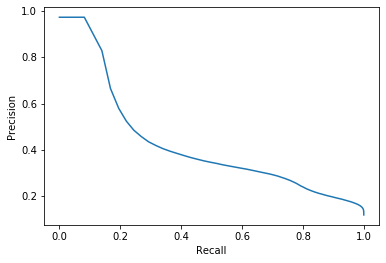

In [50]:
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Confusion Matrix

In [23]:
#from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import confusion_matrix

In [51]:
#predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
y_true = prediction.select("loan_status_binary")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1])
cnf_matrix

array([[118880,    883],
       [ 13706,   2382]])

In [25]:

import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[118880    883]
 [ 13706   2382]]


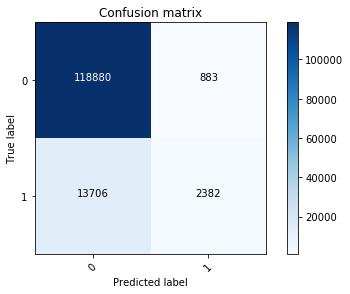

In [52]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')
plt.show()

## Gradient Boosted Trees

In [10]:
categories = ['home_ownership', 'term', 'debt_settlement_flag', 'grade_feature']
stages = []

In [11]:


for col in categories:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=col + "classVec")
    stages += [stringIndexer, encoder]

In [12]:
vectors = VectorAssembler(inputCols = ['loan_amnt', 'home_ownershipclassVec', 'termclassVec',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low',\
                                      'grade_featureclassVec','debt_settlement_flagclassVec'], 
                                 outputCol='features')

In [13]:
labelIndexer = StringIndexer(inputCol='loan_status_binary', outputCol='label')

In [14]:
gbt = GBTClassifier(maxDepth=15, maxBins=32, maxMemoryInMB=1024)
stages += [vectors, labelIndexer, gbt]

In [15]:
pipeline = Pipeline(stages=stages)

In [13]:
#paramGrid = ParamGridBuilder() \
    #.addGrid(gbt.maxDepth, [20]) \
    #.addGrid(gbt.maxBins, [50])\
    #.build()

In [14]:
#crossval = CrossValidator(estimator=pipeline,
                          #estimatorParamMaps=paramGrid,
                          #evaluator=BinaryClassificationEvaluator(),
                          #numFolds=5)

In [15]:
# Fit the pipeline
#model_gbt = crossval.fit(train)

In [16]:
model = pipeline.fit(train)

In [17]:
# Make a prediction
prediction = model.transform(test)

In [21]:
print(f'Area under P-R Curve is {evaluator.evaluate(prediction)}')
print(f'F1 Score is {f1_evaluator.evaluate(prediction)}')

Area under P-R Curve is 0.7694874501974082
F1 Score is 0.9270322603373804


In [27]:
#predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
y_true = prediction.select("loan_status_binary")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1])
cnf_matrix

array([[118247,   1516],
       [  7482,   8606]])

Confusion matrix, without normalization
[[118247   1516]
 [  7482   8606]]


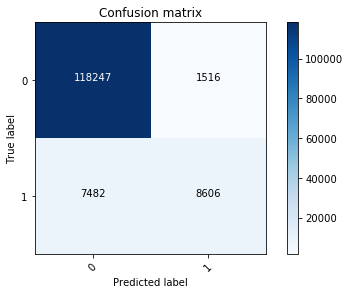

In [26]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')
plt.show()

## Random Forest

In [39]:
rf = RandomForestClassifier(maxMemoryInMB=1024)
stages[-1] = rf

In [41]:
pipeline = Pipeline(stages=stages)

In [44]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [15, 20])\
    .addGrid(rf.numTrees, [20, 25])\
    .build()

In [47]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [48]:
# Fit the pipeline
model_rf = crossval.fit(train)

In [50]:
# Make a prediction
prediction = model_rf.transform(test)
prediction.show(2)

+------------------+---------+----------+--------+--------------+-------------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+--------------------+----------------------+----------+-------------+--------------------------+----------------------------+-------------------+---------------------+--------------------+-----+--------------------+--------------------+----------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|  tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|debt_settlement_flag|grade_feature|emp_length_low|home_ownership_Index|home_ownershipclassVec|term_Index| termclassVec|debt_settlement_flag_Index|debt_settlement_flagclassVec|grade_feature_Index|grade_featureclassVec|            features|label|       rawPrediction|         probability|prediction|
+------------------+---------+----------+--------+--------------+-------------+-----------+----------+----------+---

In [51]:
print(f'Area under P-R Curve is {evaluator.evaluate(prediction)}')
print(f'F1 Score is {f1_evaluator.evaluate(prediction)}')

Area under P-R Curve is 0.5501341560444755
F1 Score is 0.8710409761086649


In [52]:
#Find Best Parameters
bestPipeline = model_rf.bestModel
bestLRModel = bestPipeline.stages[-1]
bestParams = bestLRModel.extractParamMap()
bestParams
#As with GBT, it wants higher values for parameters to improve performance

{Param(parent='RandomForestClassifier_dfd066075de7', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_dfd066075de7', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_dfd066075de7', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_dfd066075de7', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_dfd066075de7', 

## Multilayer Perceptron

In [9]:
mp = MultilayerPerceptronClassifier(seed=456)
stages[-1] = mp

NameError: name 'MultilayerPerceptronClassifier' is not defined